In [2]:
import glob
import os
import shutil
import tempfile

import nibabel as nib
import numpy as np
import torch

from monai.config import print_config
from monai.data import ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter, Dataset
from monai.transforms import (
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    LoadImaged,
)
from monai.utils import first


In [3]:
directory = os.makedirs("./monai_data", exist_ok=True)
root_dir = "./monai_data"
print(root_dir)

./monai_data


In [4]:
for i in range(5):
    im, seg = create_test_image_3d(128, 128, 128)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

In [5]:
images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        RandSpatialCrop((64, 64, 64), random_size=False),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        RandSpatialCrop((64, 64, 64), random_size=False),
    ]
)

ds = ArrayDataset(images, imtrans, segs, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([5, 1, 64, 64, 64]) torch.Size([5, 1, 64, 64, 64])


In [6]:
imtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity(), EnsureType()])

segtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), EnsureType()])

ds = ArrayDataset(images, imtrans, segs, segtrans)
patch_iter = PatchIter(patch_size=(64, 64, 64), start_pos=(0, 0, 0))


def img_seg_iter(x):
    for im, seg in zip(patch_iter(x[0]), patch_iter(x[1])):
        # uncomment this to confirm the coordinates
        # print("coord img:", im[1].flatten(), "coord seg:", seg[1].flatten())
        yield ((im[0], seg[0]),)


ds = GridPatchDataset(ds, img_seg_iter, with_coordinates=False)

loader = torch.utils.data.DataLoader(ds, batch_size=10, num_workers=0, pin_memory=torch.cuda.is_available())
im, seg = first(loader)
print("image shapes:", im.shape, seg.shape)

image shapes: torch.Size([10, 1, 64, 64, 64]) torch.Size([10, 1, 64, 64, 64])


In [7]:
from monai.data import CacheDataset, DataLoader, Dataset, DistributedSampler, SmartCacheDataset, load_decathlon_datalist
# import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

data_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/"
label_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/"
label_file = "labels.json"
with open(os.path.join(label_dir, label_file), 'r') as f:
    labels = json.load(f)

# get the image file names and labels
image_name_list = [os.path.join(data_dir, str(image_name['id'])+'.nii') for image_name in labels]


label_list = [label['age'] for label in labels]
max_age = max(label_list)
min_age = min(label_list)
label_list = [(label-min_age)/(max_age-min_age) for label in label_list] # Not sure it is still a good idea to normalize the label for spearman loss

data_dicts = []
img_list = []
for image_name, label in zip(image_name_list, label_list):
    if os.path.exists(image_name):
        data_dicts.append({"image": image_name, "label": label})
        img_list.append(image_name)
train_files, val_files = data_dicts[:-200], data_dicts[-200:]



In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image"],image_only=True, ensure_channel_first=True),
    ]
)

ds = Dataset(train_files)
for i in range(5):
    print(ds[i]["image"])
# loader = torch.utils.data.DataLoader(ds, batch_size=10, num_workers=0, pin_memory=torch.cuda.is_available())
# im, label = first(loader)

/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/2000.nii
/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/2001.nii
/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/2002.nii
/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/2003.nii
/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/2004.nii


In [9]:
import monai

transf = monai.transforms.LoadImage(image_only=True,ensure_channel_first=True)
transf_d = monai.transforms.LoadImaged(keys=["image"],image_only=True, ensure_channel_first=True)
a1 = transf("/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/2000.nii")
a_list = Dataset(img_list, transf)
loader = torch.utils.data.DataLoader(a_list, batch_size=10, num_workers=0, pin_memory=torch.cuda.is_available())
im = first(loader)
print("image shapes:", im.shape)
for i in range(2):
    print(a_list[i].shape)

ds = Dataset(train_files, transf_d)
loader = torch.utils.data.DataLoader(ds, batch_size=10, num_workers=0, pin_memory=torch.cuda.is_available())
im = first(loader)
print("image shapes:", im["image"].shape)

train_transforms = Compose(
    [
        monai.transforms.LoadImaged(keys=["image"],image_only=True, ensure_channel_first=True)
    ]
)
ds = Dataset(train_files, train_transforms)
loader = torch.utils.data.DataLoader(ds, batch_size=10, num_workers=0, pin_memory=torch.cuda.is_available())
train_loader = DataLoader(ds, batch_size=10, num_workers=4, sampler=None,shuffle=True, drop_last=True)
im = first(train_loader)
print("image shapes:", im["image"].shape)

# for a_idx in img_list:
#     a = transf(a_idx)
#     print(a.shape)
#     if a.shape != a1.shape:
#         print(a_idx)
#         print(a.shape)
#         print(a1.shape)
#         print(a_idx)
#         break

image shapes: torch.Size([10, 1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
image shapes: torch.Size([10, 1, 512, 512])
image shapes: torch.Size([10, 1, 512, 512])


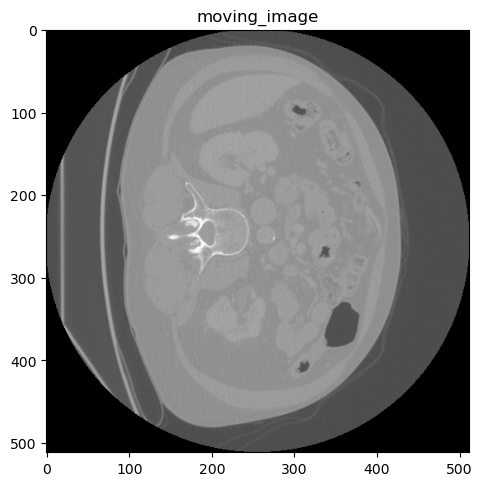

In [15]:
transf = monai.transforms.LoadImage(image_only=True,ensure_channel_first=True)
a1 = transf("/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/2004.nii")

import matplotlib.pyplot as plt

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(a1[0, :, :], cmap="gray")



plt.show()
plt.show()